In [2]:
import numpy as np
import os
import functools
import time
from pathlib import Path
from tqdm import tqdm
from allensdk.core.reference_space import ReferenceSpace
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from atlas_functions import *
from MIFFE import search_path
import ants
import nrrd
import scipy
import cv2
from PIL import Image
import nrrd
from collections import OrderedDict
import tifffile as tiff
from scipy.signal import medfilt
import time

2024-11-22 13:22:35.220826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.


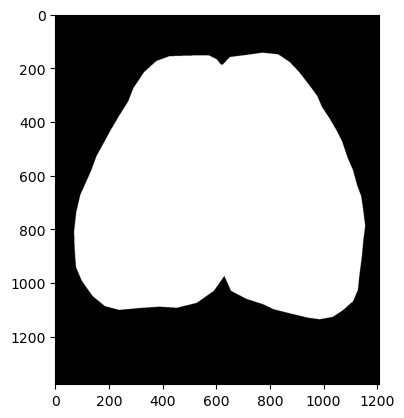

In [13]:
# obtain the surgery mask

surgery_image = cv2.imread('/Users/vincentchouinard/Documents/Maitrise/Registration/M38/surgery.jpg')

# SELECTS A MASK and outputs a binary npy

surgery_mask = select_mask(np.copy(surgery_image))

plt.imshow(surgery_mask,cmap='gist_gray')

# Cranial Window Registration

### 1. Dataset selection for registration

In [2]:
data_folder = '/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset'
registration_folder = '/Users/vincentchouinard/Documents/Maitrise/Registration'
data_ids = ['RS_M38']

In [14]:
# Folder list creation

folder_list = []
for data_id in data_ids:
    identifylist = identify_files(data_folder, keywords=[data_id])
    for i in range(len(identifylist)):
        folder_list.append(data_folder + '/' + identifylist[i])
        
        
# Surgery list creation

# mouse id creation from folder list
mouse_ids = []
for path in folder_list:
    path_end = path.split('/')[-1]
    mouse_id = path_end.split('_')[1]
    mouse_ids.append(mouse_id)


# surgery list from mouse ids
surgery_list = []
for mouse_id in mouse_ids:
    reg_mouse_path = registration_folder + '/' + identify_files(registration_folder , keywords=[mouse_id])[0]
    surgery_list.append(reg_mouse_path + '/' + identify_files(reg_mouse_path , keywords=['.jpg'])[0])
    
    
# Data files list (personal to every user. Mine is automated that way)
data_list = []
for path in folder_list:
    data_list.append(path + '/Correction/corrected_green_movie.tif')

### 2. Registering datasets

In [16]:
for i in range(len(folder_list)):
    registration(surgery_list[i], folder_list[i], data_list[i], overwrite = False, display_first = False)

100%|███████████████████████████████████████| 320/320 [00:00<00:00, 2471.23it/s]


Cortical map obtained.
Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.
Folder named "/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Registration_files" already exists.
Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.
Done!


# Transcranial Registration

In [ ]:
# Peut-être pas nécessaire si les étapes sont exactement les mêmes que celles de la fenêtre crânienne

# Coregistration

In [14]:
# outputs a cortical map of the allen institute 2017 annotation. Every id in the map are in mask_list.
isocortex_map, id_name_dict = obtain_cortical_map()
mask_list = list(id_name_dict.keys())

# outputs the mask of the allen isocortex
isocortex_mask = create_mask(isocortex_map, mask_list)

100%|███████████████████████████████████████| 320/320 [00:00<00:00, 2106.97it/s]


Cortical map obtained.


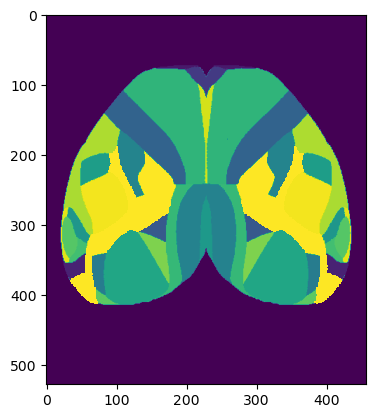

In [15]:
plt.imshow(isocortex_map,vmin=0, vmax=1000)

In [2]:
isocortex_map, id_name_dict = obtain_cortical_map()
id_name_dict

100%|███████████████████████████████████████| 320/320 [00:00<00:00, 2227.84it/s]

Cortical map obtained.


{68: 'Frontal pole, layer 1',
 97: 'Temporal association areas, layer 1',
 171: 'Prelimbic area, layer 1',
 281: 'Anteromedial visual area, layer 1',
 320: 'Primary motor area, Layer 1',
 421: 'Lateral visual area, layer 1',
 442: 'Retrosplenial area, dorsal part, layer 1',
 450: 'Primary somatosensory area, upper limb, layer 1',
 484: 'Orbital area, medial part, layer 1',
 527: 'Dorsal auditory area, layer 1',
 542: 'Retrosplenial area, ventral part, layer 1',
 558: 'Primary somatosensory area, nose, layer 1',
 593: 'Primary visual area, layer 1',
 656: 'Secondary motor area, layer 1',
 671: 'Retrosplenial area, lateral agranular part, layer 1',
 696: 'Posterior auditory area, layer 1',
 735: 'Primary auditory area, layer 1',
 750: 'Posterolateral visual area, layer 1',
 805: 'posteromedial visual area, layer 1',
 836: 'Ectorhinal area/Layer 1',
 873: 'Supplemental somatosensory area, layer 1',
 878: 'Primary somatosensory area, mouth, layer 1',
 897: 'Visceral area, layer 1',
 935: '

In [1]:
rsp, tree = open_AllenSDK()
isocortex_map, id_name_dict, _ = map_generator(rsp, tree, structure='Isocortex', depth=4)
plt.imshow(isocortex_map, vmin=0, vmax=1000)

NameError: name 'open_AllenSDK' is not defined

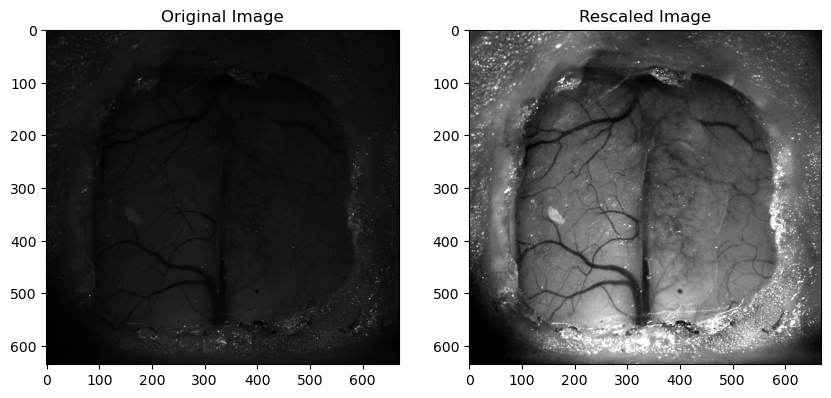

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def intensity_bounds_v3(im, percentile=0.05):
    """
    Adjusts the intensity values of an image based on given percentiles and rescales the image to 8-bit.
    
    Args:
    im (np.array): The input image loaded with cv2.IMREAD_UNCHANGED.
    percentile (float): The percentile for clipping the intensity values (default is 0.05 for 5-95% range).
    
    Returns:
    np.array: The rescaled 8-bit image.
    """
    # Calculate the lower and upper percentile bounds
    vmin = np.percentile(im, percentile * 100)
    vmax = np.percentile(im, (1 - percentile) * 100)

    # Clip the image values to the percentile bounds
    clipped_im = np.clip(im, vmin, vmax)

    # Rescale the image to the 0-255 range
    rescaled_im = ((clipped_im - vmin) / (vmax - vmin) * 255).astype(np.uint8)

    return rescaled_im

# Example usage
image_path = '/Volumes/DDE_Chouine/M38_forepaw_13fev/Correction/green_movie.tif'
im = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Ensure the image is read correctly
if im is None:
    raise ValueError("Image not loaded correctly. Please check the file path and format.")

# Rescale the 12-bit image to 8-bit
rescaled_im = intensity_bounds_v3(im, percentile=0.01)

# Display the original and rescaled images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(im, cmap='gray', vmin=np.min(im), vmax=np.max(im))

plt.subplot(1, 2, 2)
plt.title("Rescaled Image")
plt.imshow(rescaled_im, cmap='gray')
plt.show()

In [98]:
dHbT = tiff.imread('/Volumes/DDE_Chouine/M38_stim_13fev/Hb_data/dHbT.tif')
mask_folder_path = '/Volumes/DDE_Chouine/M38_stim_13fev/Masks'
files = identify_files(mask_folder_path, 'mask_')

In [107]:
from scipy.ndimage import gaussian_filter1d

id_list = [int(name.split('_')[1].split('.')[0]) for name in files]
id_list.sort()
sorted_files = [f'mask_{id}.tif' for id in id_list]

def bin_pixels(frame, bin_size):
    height, width = frame.shape[:2]
    binned_height = height // bin_size
    binned_width = width // bin_size

    reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)
    binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
    binned_frame = binned_frame / (bin_size**2)

    return binned_frame

timeseries = np.zeros((len(sorted_files), dHbT.shape[0]))
for i, mask_name in enumerate(sorted_files):
    mask = tiff.imread(mask_folder_path + '/' + mask_name)
    binned_mask = bin_pixels(mask, 2)
    # Assuming binned_mask and dHbT are numpy arrays of the same shape
    masked_values = binned_mask * dHbT

    # Create a boolean mask for non-zero values
    non_zero_mask = masked_values != 0

    # Calculate the mean of non-zero values along the desired axes
    mean_response = np.sum(masked_values, axis=(1, 2)) / np.sum(non_zero_mask, axis=(1, 2))
    timeseries[i, :] = mean_response
    
from matplotlib.font_manager import FontProperties

def plot_timeseries(ts_stack, id_list):
    fig, ax = plt.subplots(figsize=(12,8), dpi = 120)
    n_ts = ts_stack.shape[0]
    height = 0
    font = FontProperties(family='Times New Roman', weight='bold', size=12)
    
    for i in range(n_ts):
        plt.plot(ts_stack[i,:] + height, '-k')
        plt.text(-30, ts_stack[i, :][0] + height, str(id_list[i]) + ' ', fontproperties=font, va='center', ha='right')
        height += 2.4
    plt.yticks([])
    return None
    
stims1 = [(60, 180), (240, 360), (420, 540)]
stims2 = [(60, 180), (240, 360), (420, 540), (600,720), (780,900)]

def mean_responses(timeseries, stims):
    mean_responses = np.zeros((len(stims), 120))
    
    for i, (start, end) in enumerate(stims):
        response = timeseries[start:end]
        mean_responses[i, :] = response
    
    mean = np.mean(mean_responses, axis=0)
    
    return mean

In [108]:
fore = gaussian_filter1d(mean_responses(timeseries[3],stims2),sigma=1)
hind = gaussian_filter1d(mean_responses(timeseries[12],stims2),sigma=1)
whisk = gaussian_filter1d(mean_responses(timeseries[10],stims2),sigma=1)

In [72]:
hind[64:72] += -0.05

In [111]:
np.max(whisk)

8.826633705968362

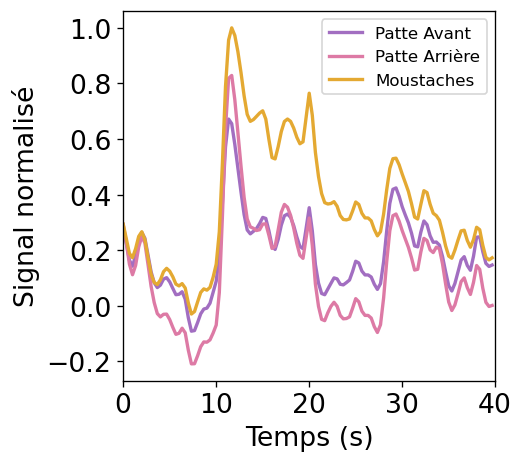

In [112]:
color_fore = '#A26EC1'
color_lower = '#DD7AA5'
color_whisk = '#E4A932'
fig,ax=plt.subplots(figsize=(4,4),dpi=120)

# Plotting the data
#plt.plot(fore, linewidth=2, label='Patte Avant')  # Add label for legend
plt.plot(fore/np.max(whisk), linewidth=2, label='Patte Avant', color=color_fore)
plt.plot(hind/np.max(whisk), linewidth=2, label='Patte Arrière', color=color_lower)
plt.plot(whisk/np.max(whisk), linewidth=2, label='Moustaches', color=color_whisk)


# Customizing font sizes for labels and ticks
font_size = 16  # You can change this value as needed
plt.xlabel('Temps (s)', fontsize=font_size)
plt.ylabel('Signal normalisé', fontsize=font_size)
plt.xticks([0, 30, 60, 90, 120], [0, 10, 20, 30, 40], fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlim([0,120])

# Adding a legend
plt.legend()

# Display the plot
plt.savefig("/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Colloque/puffs.svg")

# timeseries with masks figure

In [ ]:
import tifffile as tiff

def load_masks(folder):
    """Load all .tif files from the specified folder using tifffile."""
    masks = []
    for filename in os.listdir(folder):
        if filename.endswith(".tif"):
            filepath = os.path.join(folder, filename)
            try:
                mask = tiff.imread(filepath)
                if mask.dtype == np.uint64:  # Check if the image is indeed 64-bit
                    mask = (mask / np.max(mask) * 255).astype(np.uint8)  # Normalize and convert to 8-bit
                masks.append(mask)
            except Exception as e:
                print(f"Failed to load: {filename} with error: {e}")
    return masks

def find_contours(masks):
    """Find contours in each mask."""
    all_contours = []
    for mask in masks:
        # Find contours at a constant value of 255
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        all_contours.extend(contours)
    return all_contours

def plot_contours(contours):
    """Plot all contours."""
    plt.figure(figsize=(10, 10))
    for contour in contours:
        plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='black', linewidth=8)
    plt.gca().invert_yaxis()  # Invert the y-axis to match image coordinates
    plt.axis('off')  # Turn off the axis
    plt.show()

# Directory containing the masks
folder_path = '/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Masks'

# Load masks
masks = load_masks(folder_path)

# Find contours
contours = find_contours(masks)

# Plot contours
plot_contours(contours)

(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)
(1800, 292, 336)


([], [])

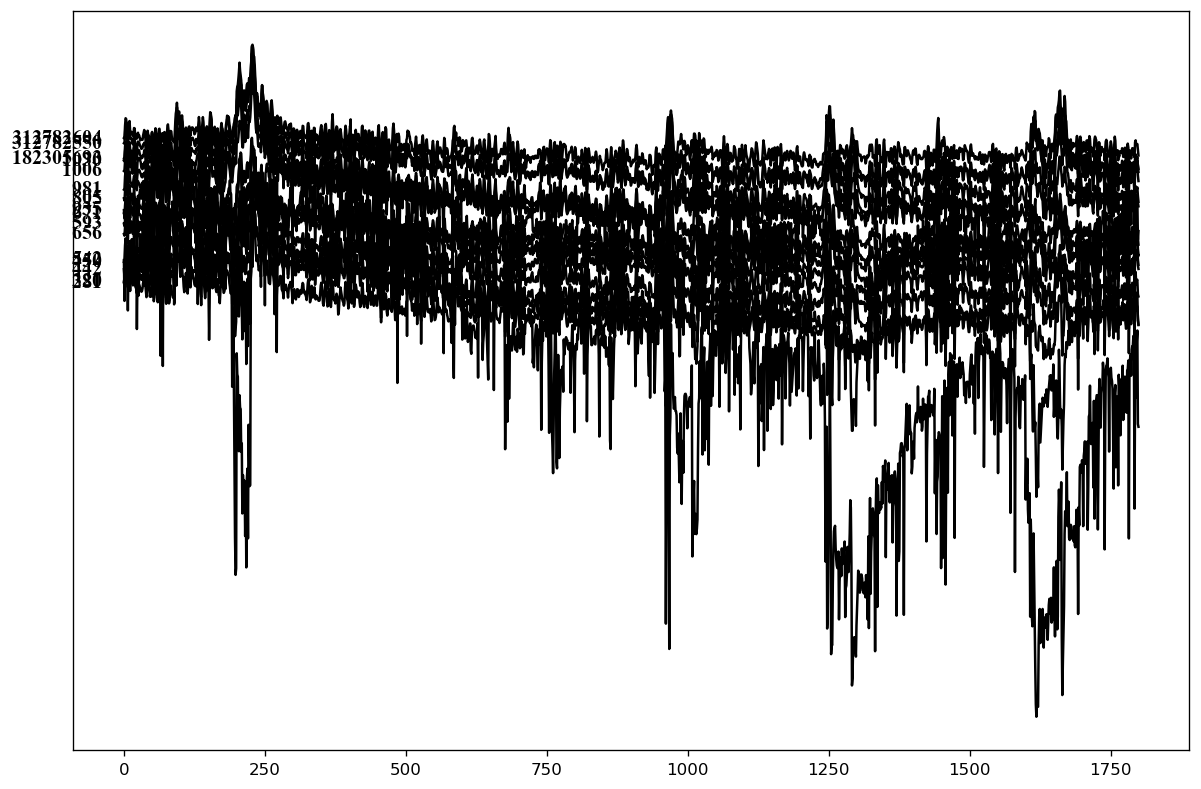

In [53]:
dHbT = tiff.imread('/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Hb_data/dHbT.tif')
mask_folder_path = '/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Masks'
files = identify_files(mask_folder_path, 'mask_')

id_list = [int(name.split('_')[1].split('.')[0]) for name in files]
id_list.sort()
sorted_files = [f'mask_{id}.tif' for id in id_list]

([], [])

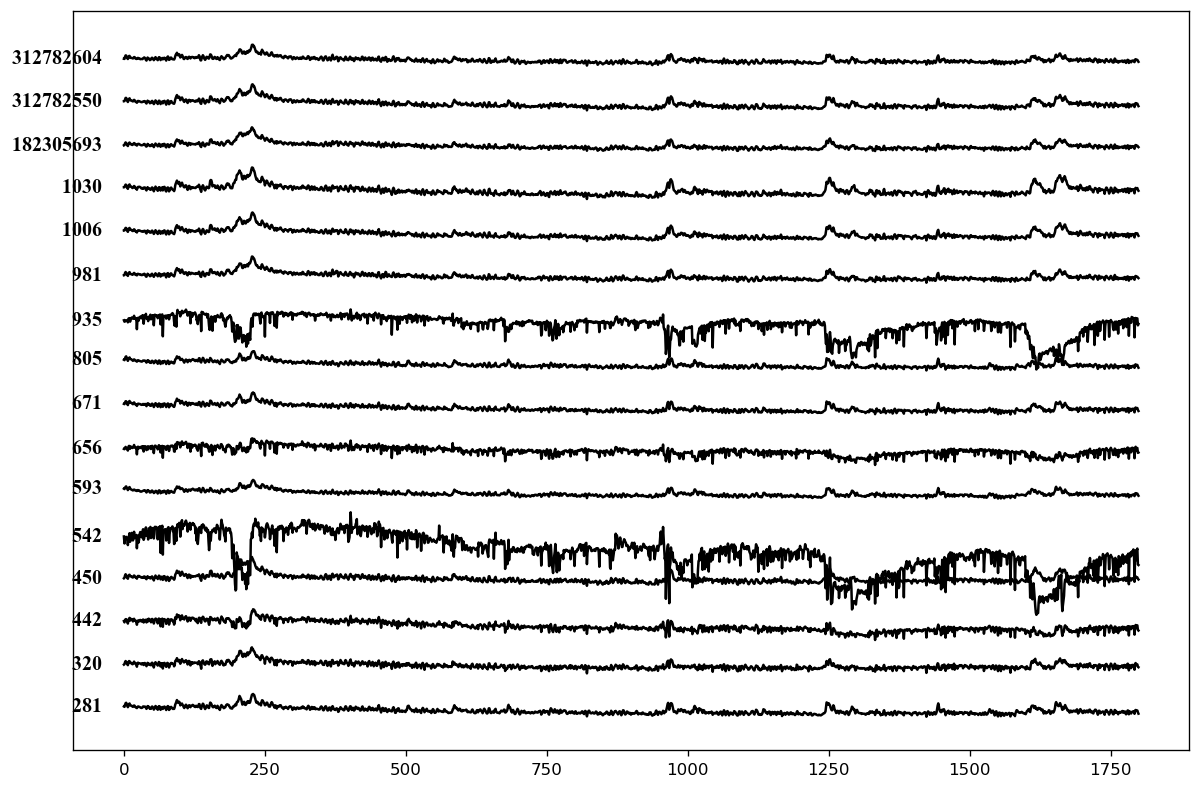

In [96]:
def bin_pixels(frame, bin_size):
    height, width = frame.shape[:2]
    binned_height = height // bin_size
    binned_width = width // bin_size

    reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)
    binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
    binned_frame = binned_frame / (bin_size**2)

    return binned_frame

timeseries = np.zeros((len(sorted_files), dHbT.shape[0]))
for i, mask_name in enumerate(sorted_files):
    mask = tiff.imread(mask_folder_path + '/' + mask_name)
    binned_mask = bin_pixels(mask, 2)
    
    # Assuming binned_mask and dHbT are numpy arrays of the same shape
    masked_values = binned_mask * dHbT

    # Create a boolean mask for non-zero values
    non_zero_mask = masked_values != 0

    # Calculate the mean of non-zero values along the desired axes
    mean_response = np.sum(masked_values, axis=(1, 2)) / np.sum(non_zero_mask, axis=(1, 2))
    timeseries[i, :] = mean_response
    
from matplotlib.font_manager import FontProperties


fig, ax = plt.subplots(figsize=(12,8), dpi = 120)
n_ts = timeseries.shape[0]
height = 0
font = FontProperties(family='Times New Roman', weight='bold', size=12)

for i in range(n_ts):
    plt.plot(timeseries[i,:] + height, '-k')
    plt.text(-30, timeseries[i, :][0] + height, str(id_list[i]) + ' ', fontproperties=font, va='center', ha='right')
    height += 60
plt.yticks([])

    

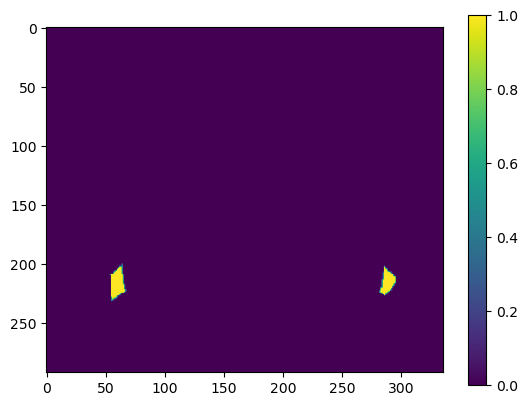

In [54]:
binned_mask = bin_pixels(mask, 2)
plt.imshow(binned_mask)
plt.colorbar()

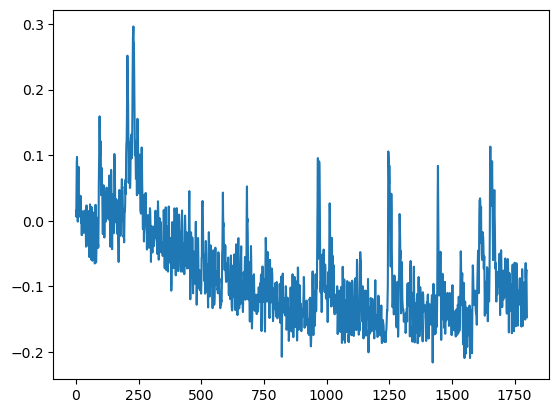

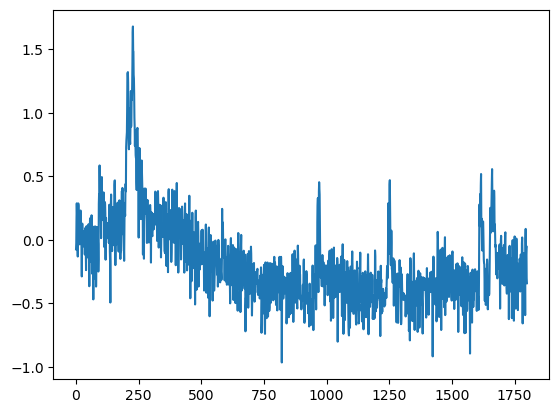

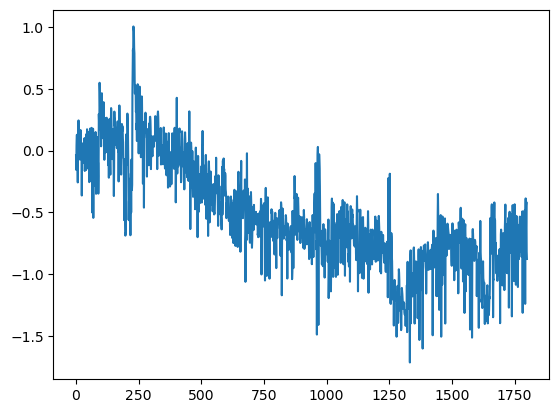

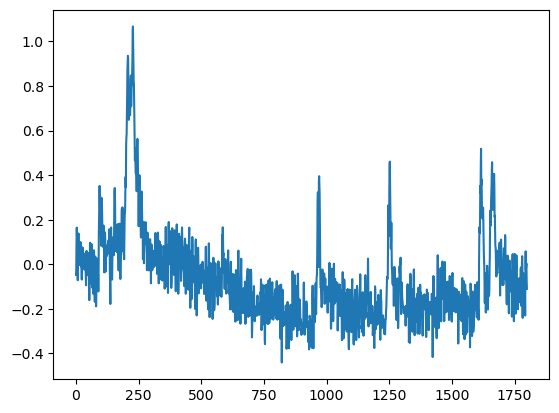

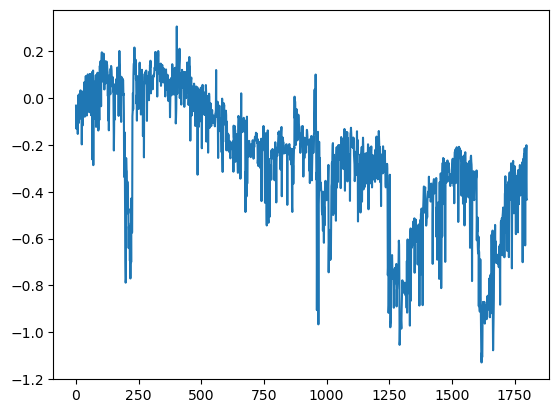

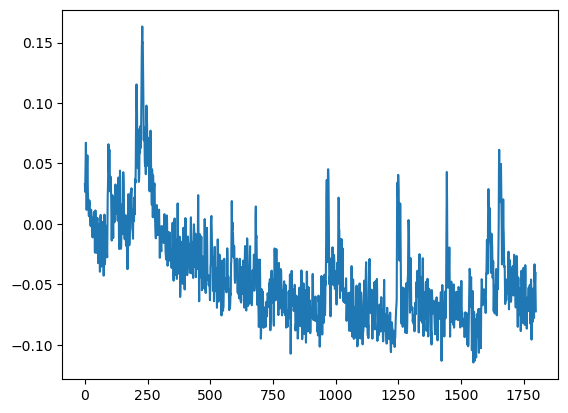

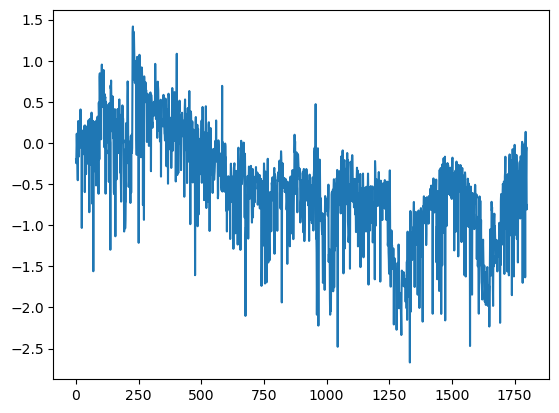

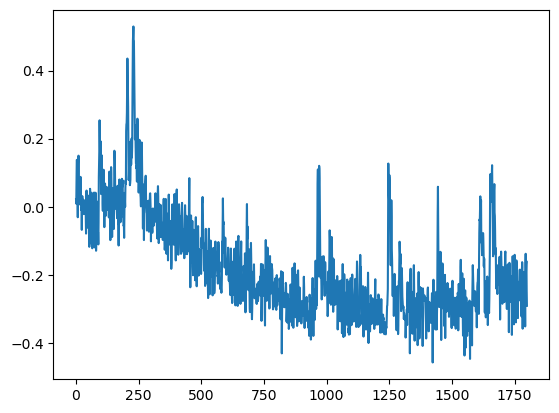

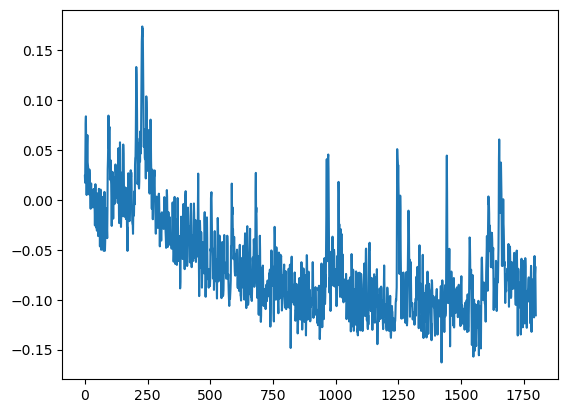

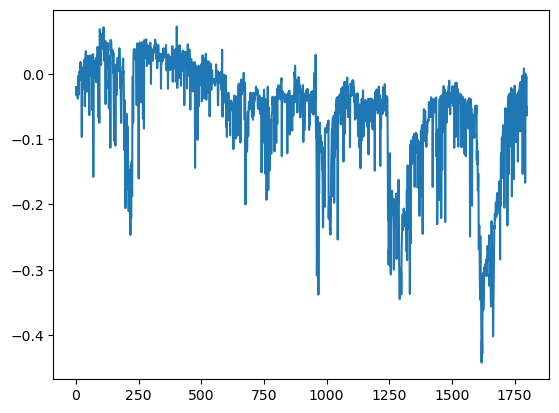

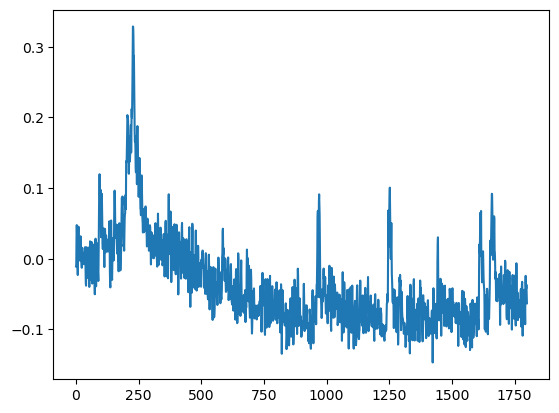

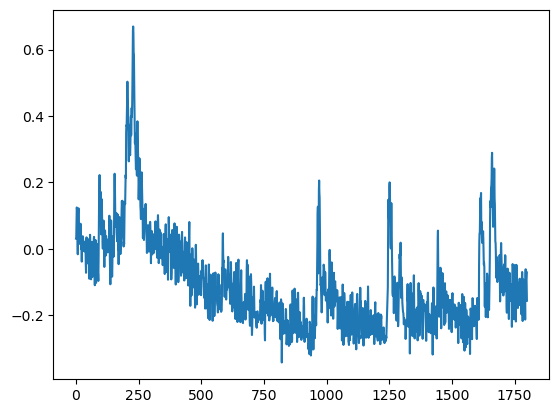

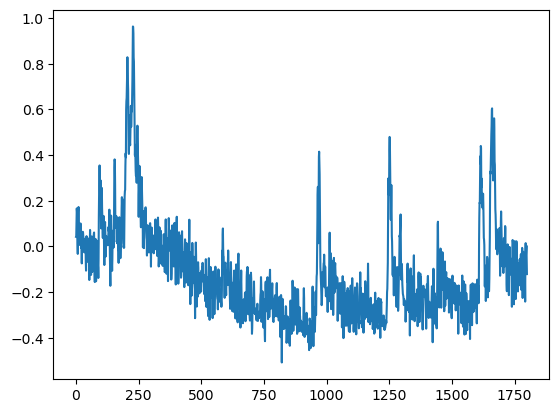

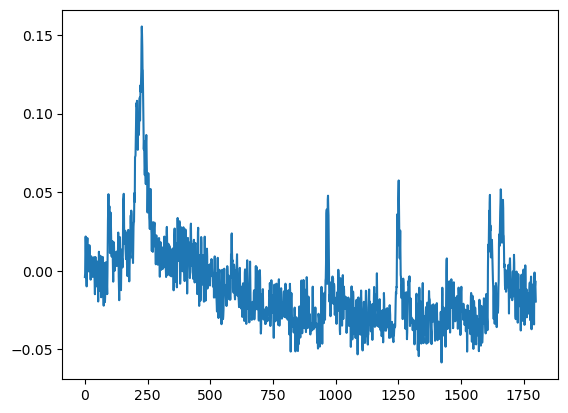

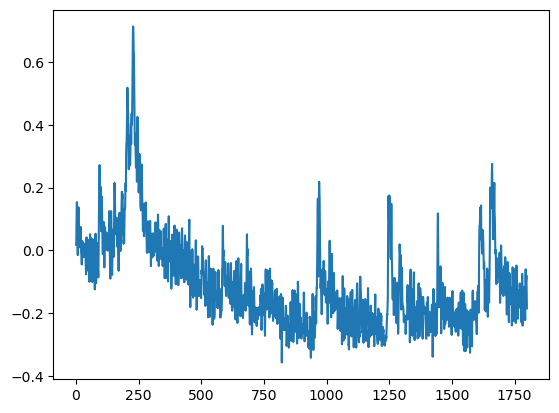

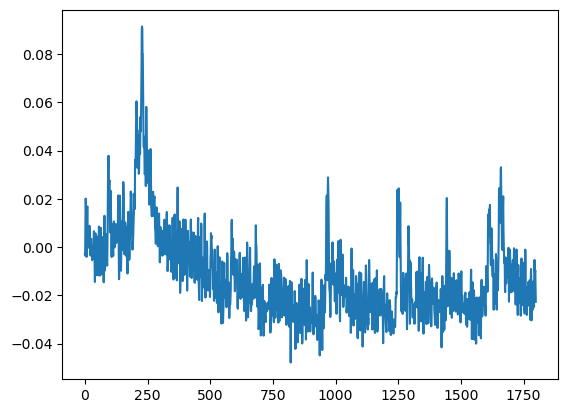

In [20]:
for i in range(timeseries.shape[0]):
    plt.plot(timeseries[i,:])
    plt.show()

In [25]:
# Calculate the mean of all time series
mean_timeseries = np.mean(timeseries, axis=0)

# Fit a quadratic polynomial to the mean trend
x = np.arange(mean_timeseries.shape[0])
coeffs = np.polyfit(x, mean_timeseries, 2)
mean_trend = np.polyval(coeffs, x)

# Subtract the mean trend from each time series
detrended_timeseries = timeseries - mean_trend

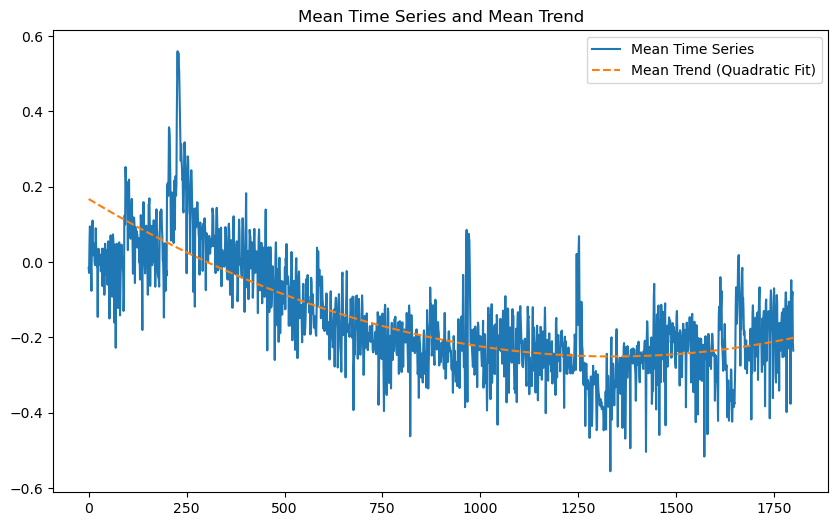

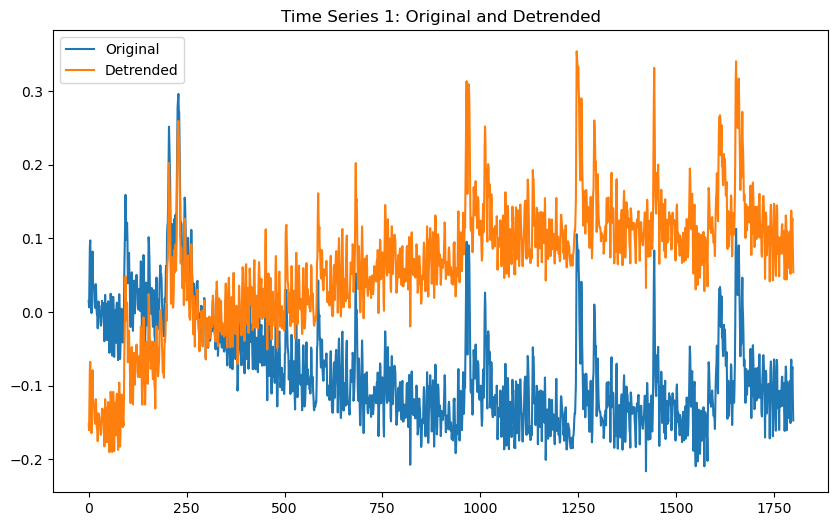

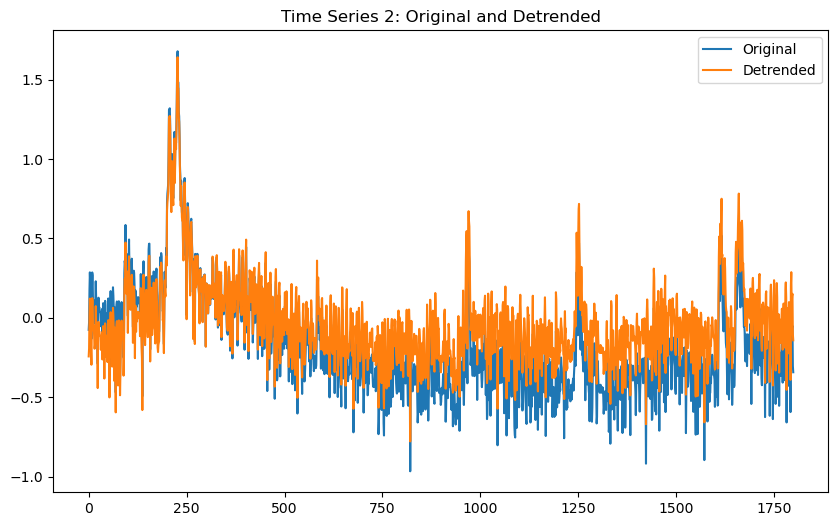

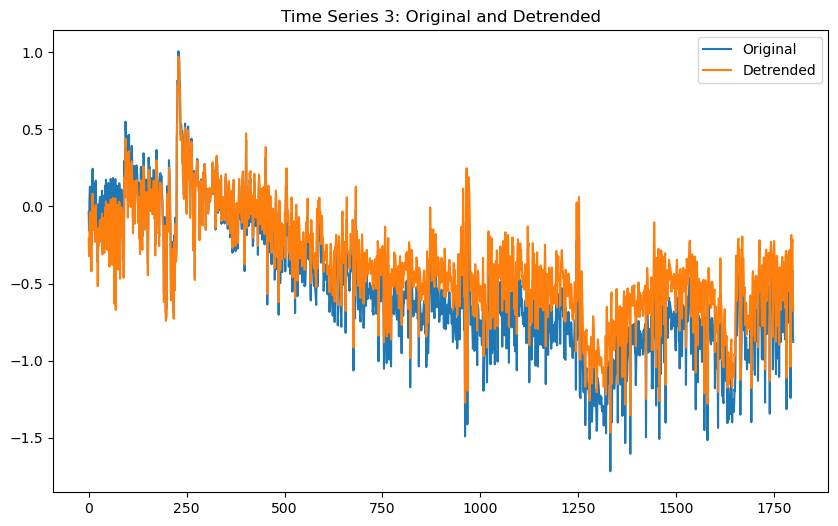

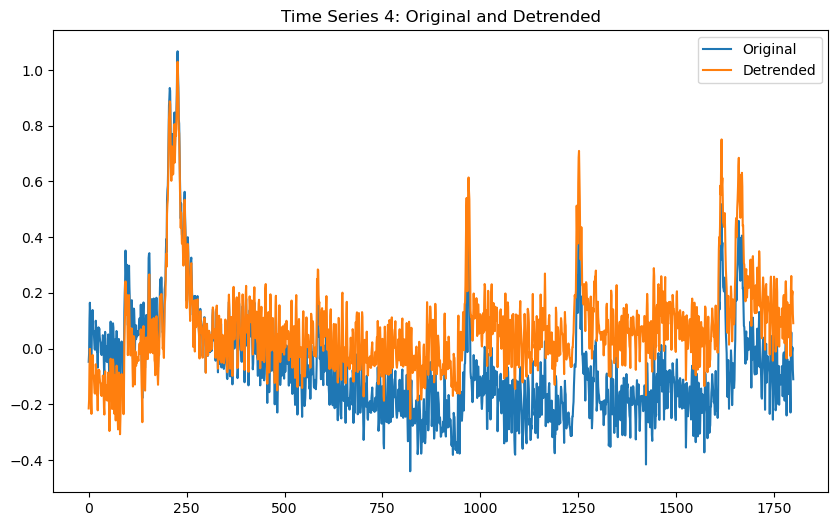

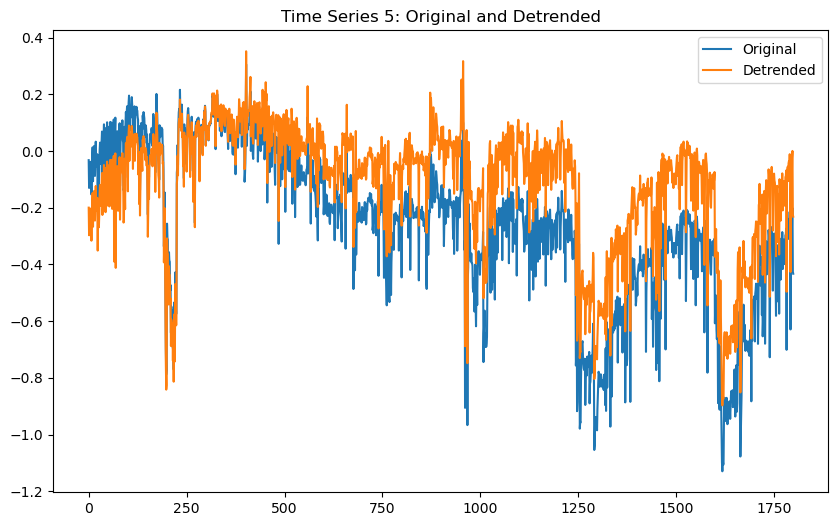

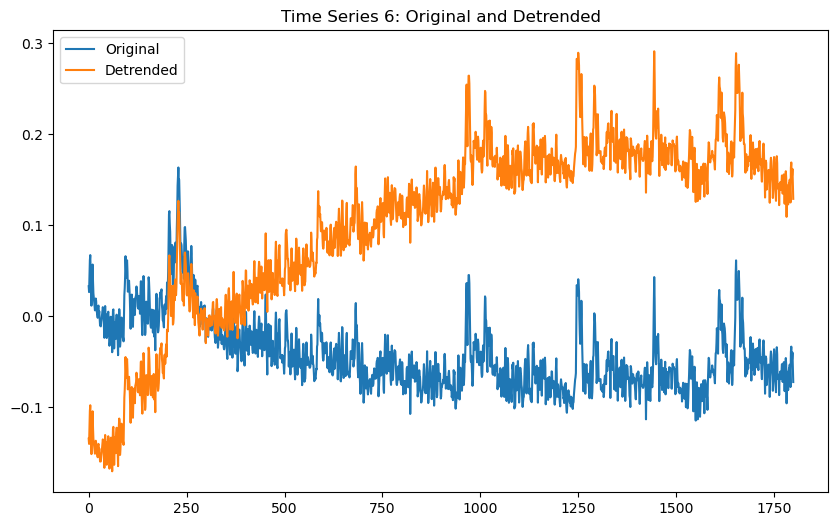

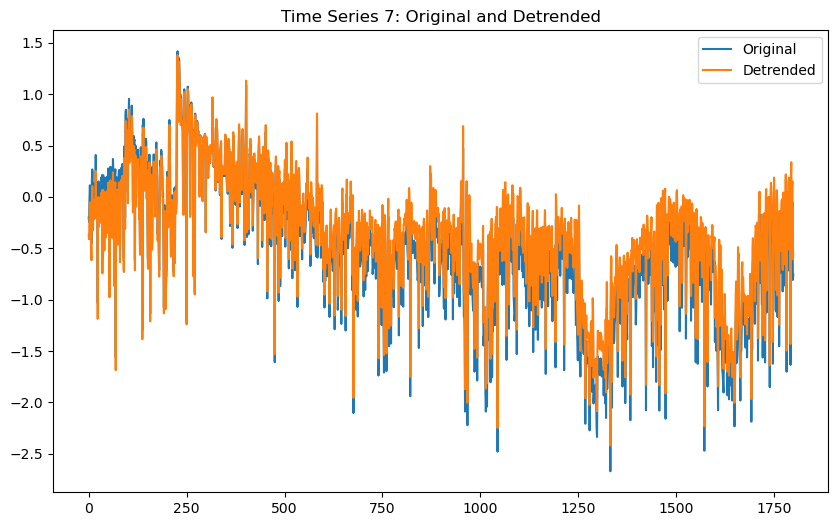

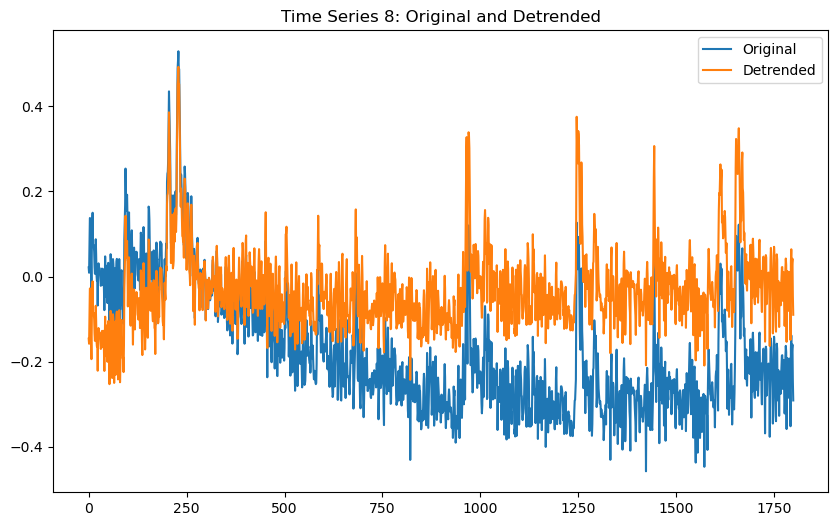

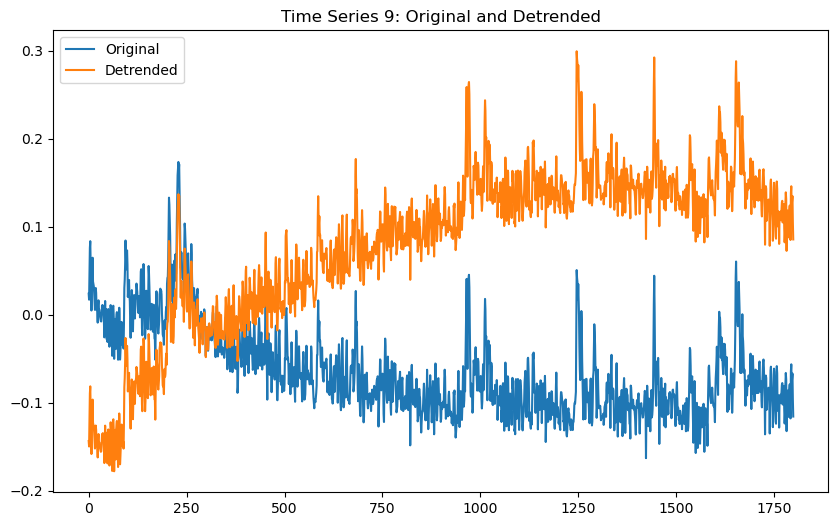

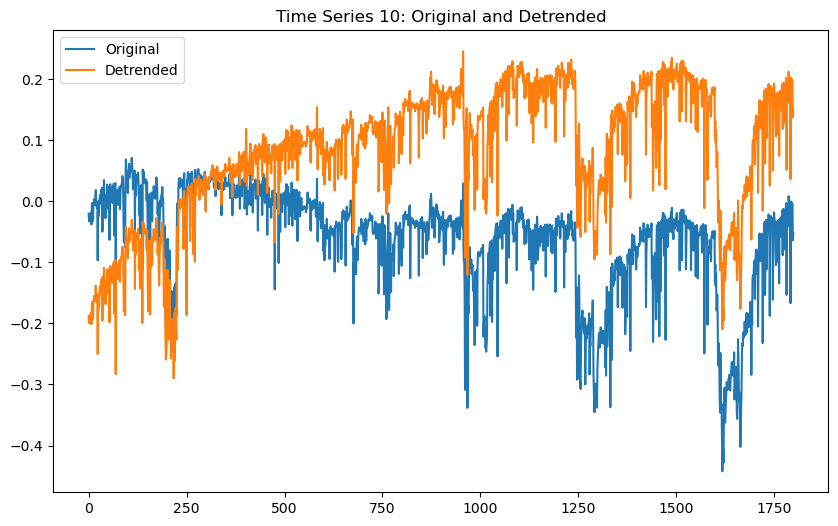

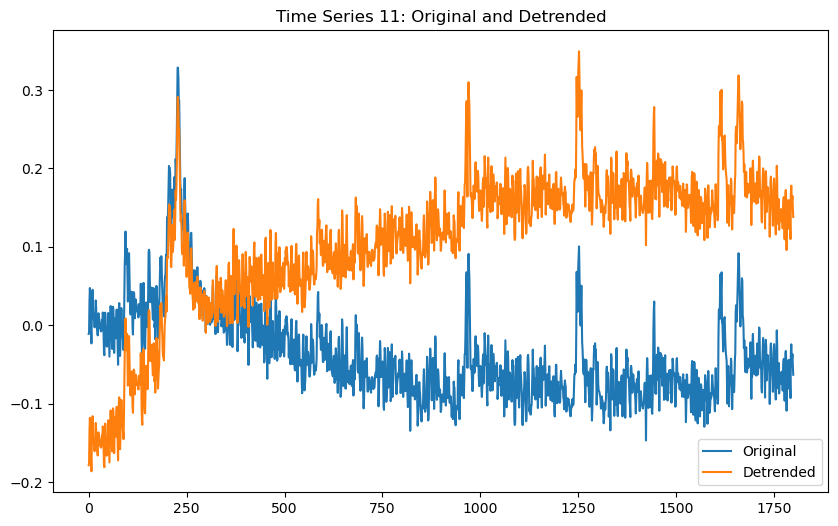

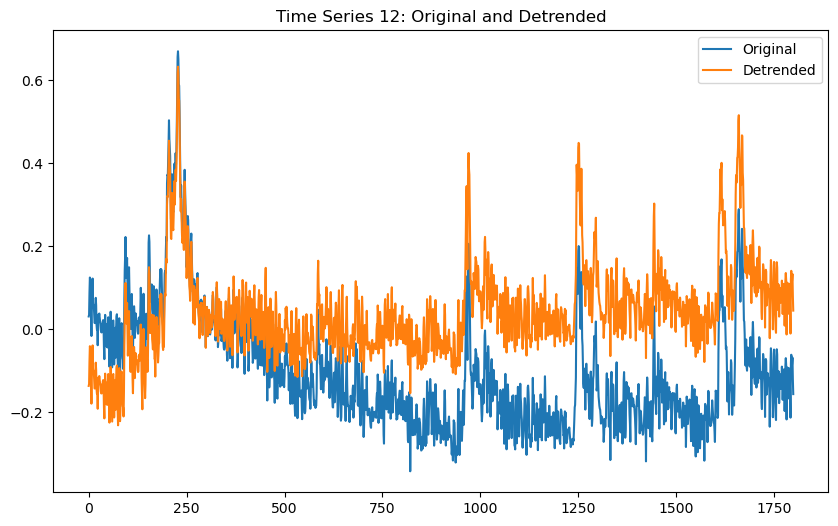

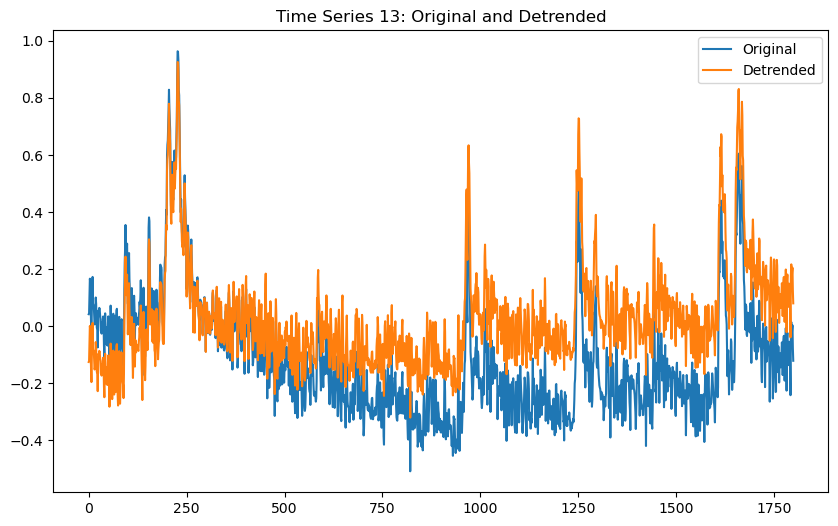

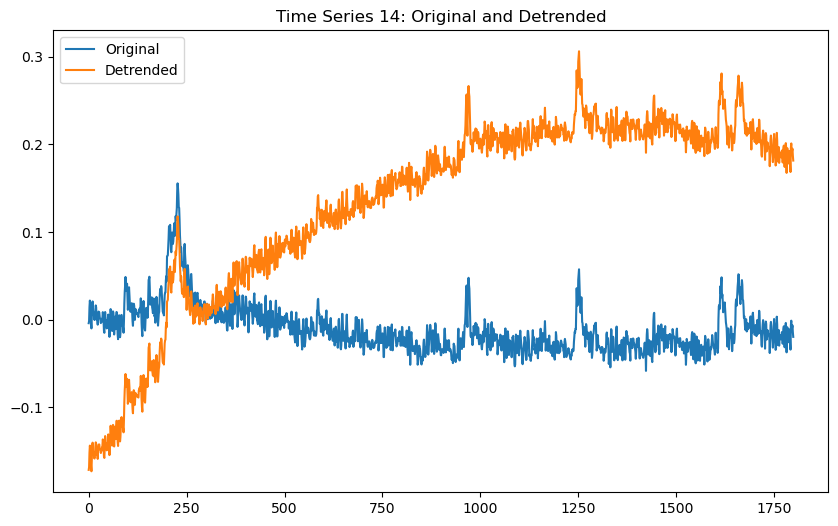

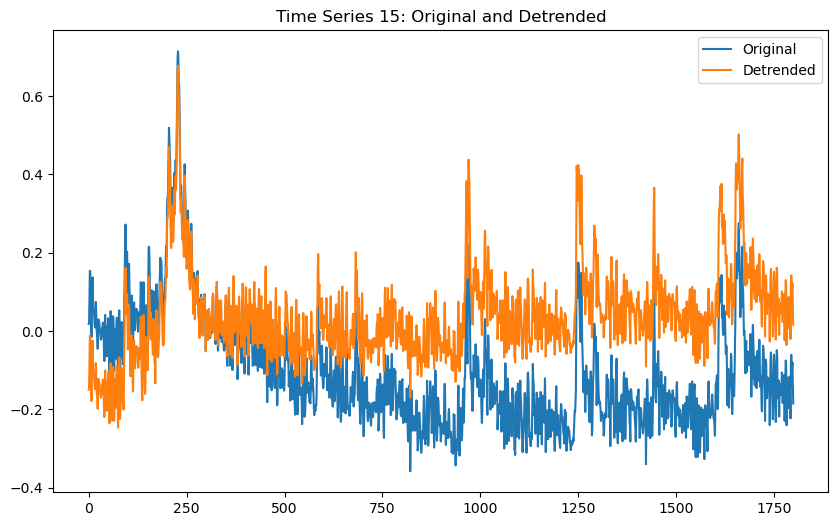

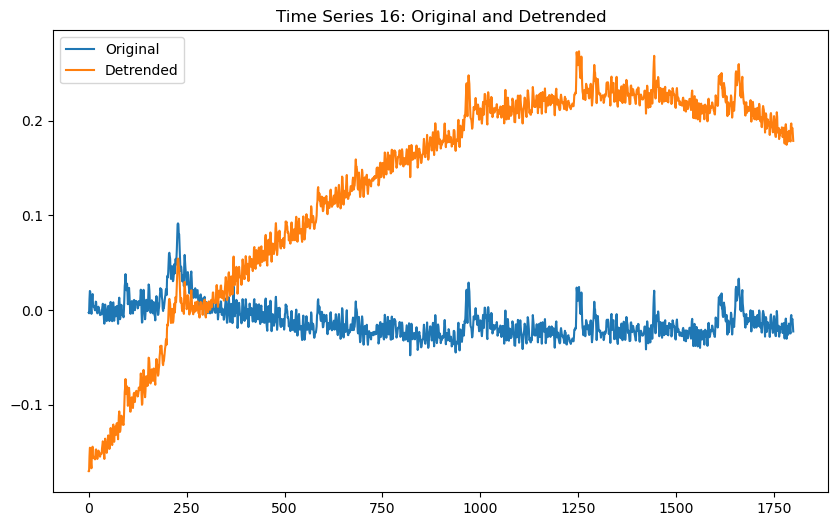

In [26]:
# Plot the mean trend
plt.figure(figsize=(10, 6))
plt.plot(x, mean_timeseries, label='Mean Time Series')
plt.plot(x, mean_trend, label='Mean Trend (Quadratic Fit)', linestyle='--')
plt.legend()
plt.title("Mean Time Series and Mean Trend")
plt.show()

# Plot the original and detrended time series
for i in range(timeseries.shape[0]):
    plt.figure(figsize=(10, 6))
    plt.plot(x, timeseries[i, :], label='Original')
    plt.plot(x, detrended_timeseries[i, :], label='Detrended')
    plt.legend()
    plt.title(f"Time Series {i+1}: Original and Detrended")
    plt.show()

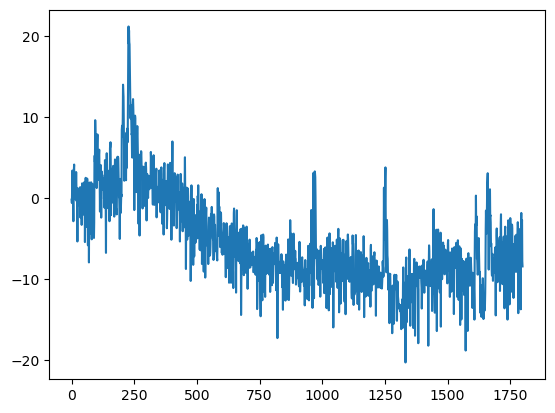

In [40]:
from scipy.ndimage import gaussian_filter1d
trend = np.mean(dHbT[:,70:230,80:270],axis=(1,2))
plt.plot(trend)

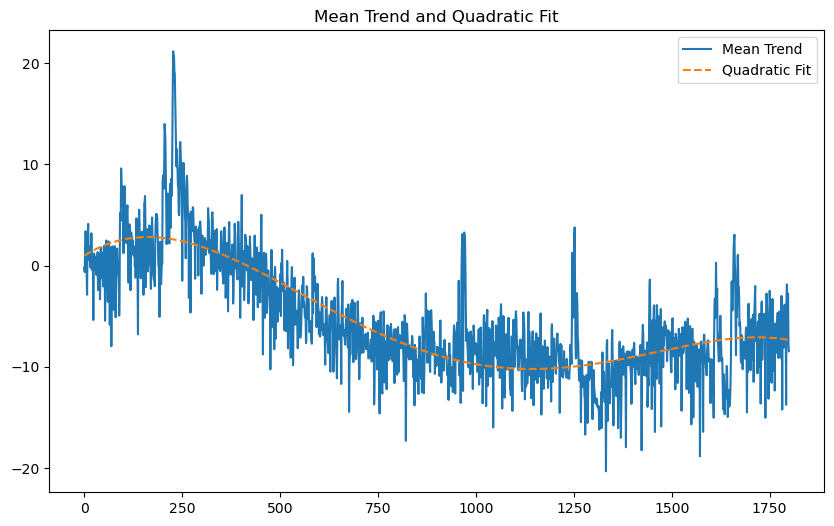

In [58]:
# Assuming trend is your mean trend array
x = np.arange(trend.shape[0])
coeffs = np.polyfit(x, trend, 4)
mean_trend_fit = np.polyval(coeffs, x)

# Plot the mean trend and the quadratic fit
plt.figure(figsize=(10, 6))
plt.plot(x, trend, label='Mean Trend')
plt.plot(x, mean_trend_fit, label='Quadratic Fit', linestyle='--')
plt.legend()
plt.title("Mean Trend and Quadratic Fit")
plt.show()

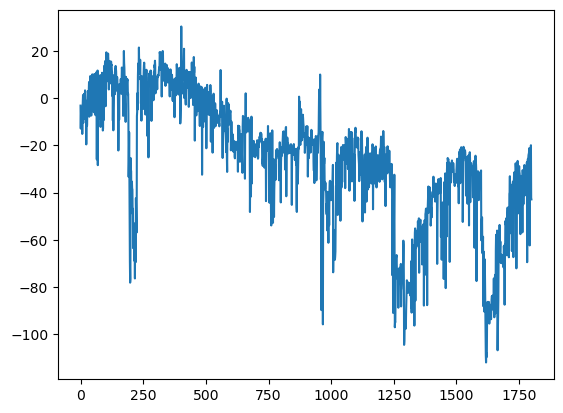

In [60]:
plt.plot(timeseries[4])

In [87]:
# Assuming timeseries is your original data array
detrended_timeseries = timeseries - trend

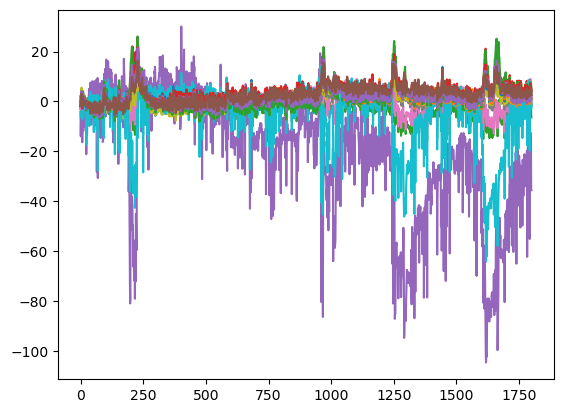

In [63]:
for i in range(detrended_timeseries.shape[0]):
    plt.plot(detrended_timeseries[i,:])

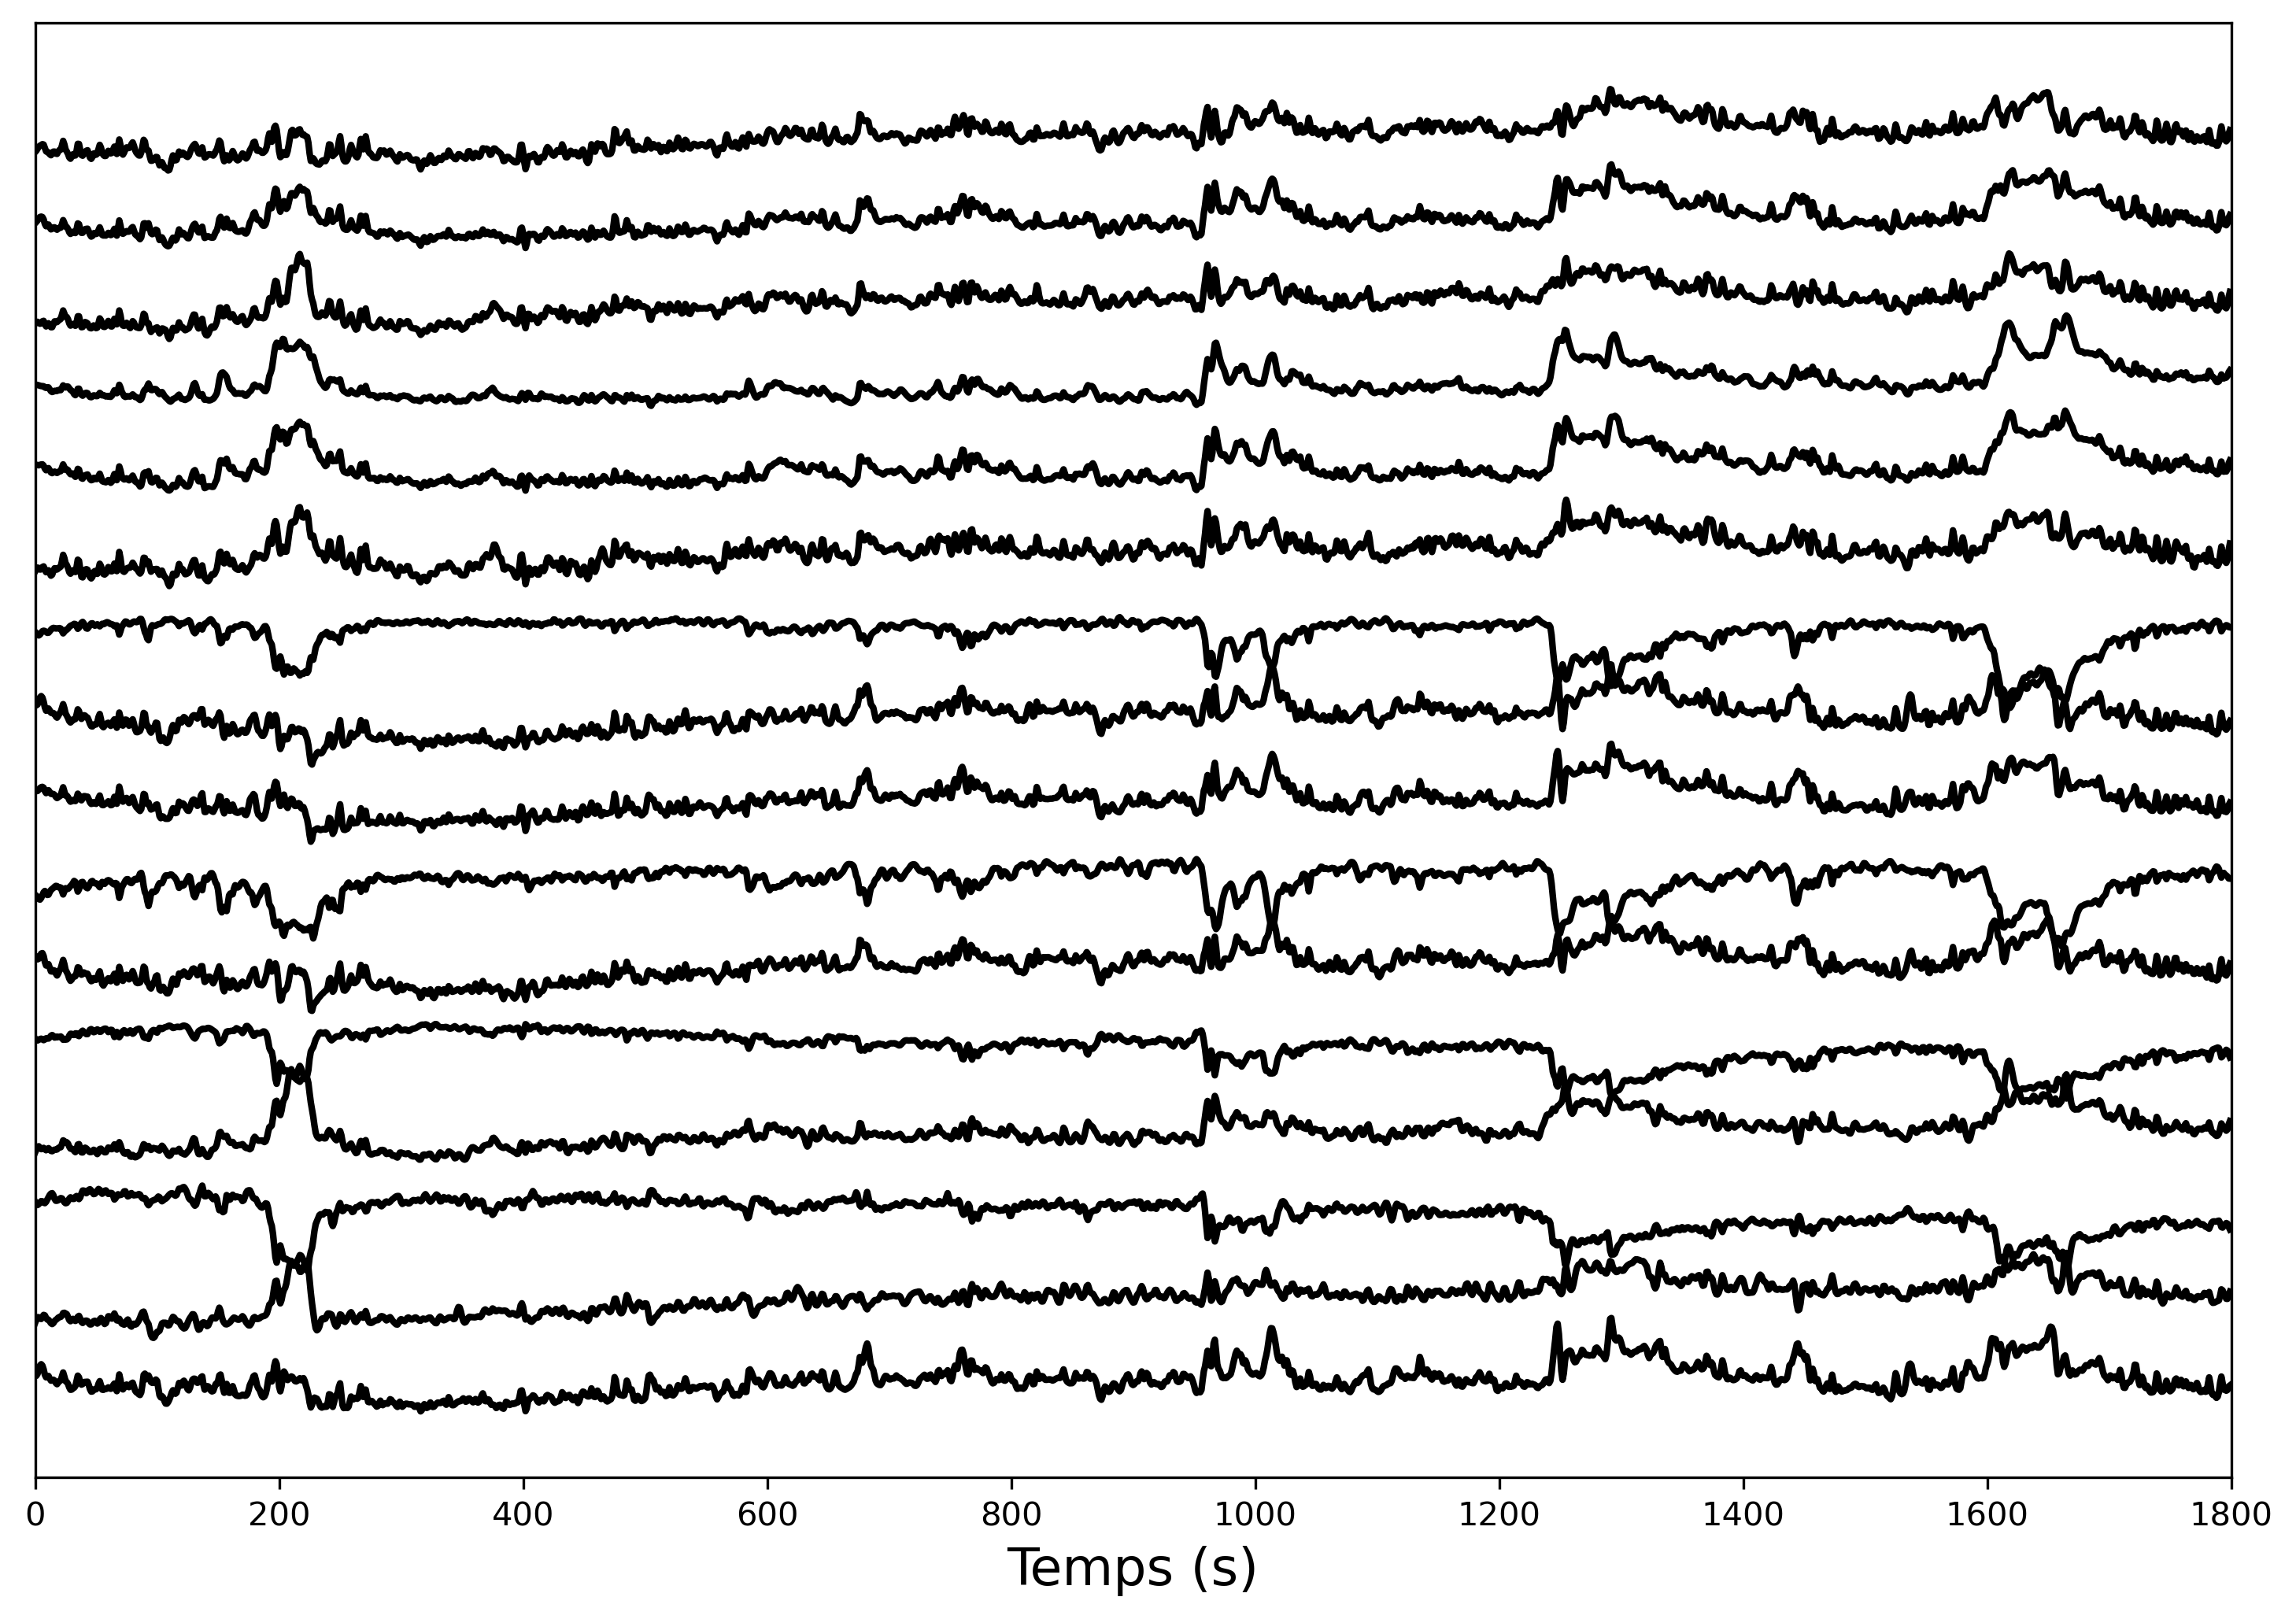

In [97]:
mean = np.mean(detrended_timeseries, axis=1, keepdims=True)
std = np.std(detrended_timeseries, axis=1, keepdims=True)

z_normalized_timeseries = (detrended_timeseries - mean) / std

fig,ax=plt.subplots(figsize=(12,8),dpi=300)
count=0
for i in range(z_normalized_timeseries.shape[0]):
    plt.plot(gaussian_filter1d(z_normalized_timeseries[i, :]+count,sigma=1), color = 'black', linewidth=2)
    count+=5
plt.xlim([0,1800])
plt.xlabel('Temps (s)', fontsize=16)
plt.yticks([])
#plt.xticks(fontsize=16)

#plt.title("Z-score Normalized Time Series")
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Colloque/timeseries_v2.svg')

# 